<h1>Fine tuning GPT-3 Model<h1>
    <h5>We try to Fine tune OpenAI's GPT-3 models (Ada and Curie) using cleaned tweets to classify tweets related to CCS<h5>

In [1]:
#importing libraires 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import openai
from sklearn import metrics
import matplotlib.pyplot as plt

In [4]:
#load cleaned tweets dataset
train_df = pd.read_pickle('./train_df_cleaned.pkl')
test_df = pd.read_pickle('./test_df_cleaned.pkl')

In [5]:
#Add text labels (since GPT is languge based model)
train_df['label'] = train_df['related_manual'].map({0:'Other',1:'Carbon Capture, Usage and Storage'})
test_df['label'] = test_df['related_manual'].map({0:'Other',1:'Carbon Capture, Usage and Storage'})

In [6]:
train_df['label'].value_counts()

label
Carbon Capture, Usage and Storage    1000
Other                                1000
Name: count, dtype: int64

In [7]:
test_df['label'].value_counts()

label
Carbon Capture, Usage and Storage    250
Other                                250
Name: count, dtype: int64

In [8]:
#Change columns names for matching finetuning format 
train_data = pd.DataFrame({'prompt':train_df.tweet_preprocessed,'completion':train_df.label})
test_data = pd.DataFrame({'prompt':test_df.tweet_preprocessed,'completion':test_df.label})

In [16]:
train_data

,prompt,completion
0,nonelectricfuel mowers2 dont mow let wild lown...,"Carbon Capture, Usage and Storage"
1,youll need explain carbon sink comment commerc...,"Carbon Capture, Usage and Storage"
2,excellent clip simon yes difficult value maybe...,"Carbon Capture, Usage and Storage"
3,looking different habitats provide stack biodi...,"Carbon Capture, Usage and Storage"
4,carbon sequestration calcs opportunities orgs ...,"Carbon Capture, Usage and Storage"
...,...,...
1995,ge manifesto prioritise brownfield sites prote...,Other
1996,responsible suppliers maintaining forestland f...,"Carbon Capture, Usage and Storage"
1997,minister forestry environment siti nuraya baka...,Other
1998,good luck opposing today terrible foothold dis...,Other


In [9]:
test_data['completion'].value_counts()

completion
Carbon Capture, Usage and Storage    250
Other                                250
Name: count, dtype: int64

In [10]:
#Save as json files
train_data.to_json("./train_cleaned.jsonl", orient='records', lines=True)
test_data.to_json("./test_cleaned.jsonl", orient='records', lines=True)

In [12]:
#helper to create training file instance
def create_training_file(file_path):
    file = openai.File.create(
        file=open(file_path, "rb"),
        purpose='fine-tune'
    )
    return file

training_file_cleaned = create_training_file("./train_cleaned_prepared.jsonl")
print(training_file_cleaned)

{
  "object": "file",
  "id": "file-vNcVYVnfeCGg2gJPDlfICSJR",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 303191,
  "created_at": 1692015209,
  "status": "uploaded",
  "status_details": null
}


In [14]:
#create fine tuning job for Ada model
fine_tuned_model_1 = openai.FineTune.create(training_file = training_file_cleaned['id'], 
                                            model = "ada", 
                                            n_epochs = 4,
                                            prompt_loss_weight=0.01,
                                            learning_rate_multiplier=0.1,
                                            suffix="cleaned_14-Aug_ada")

In [13]:
#create fine tuning job for Curie model
fine_tuned_model_2 = openai.FineTune.create(training_file = training_file_cleaned['id'], 
                                            model = "curie", 
                                            n_epochs = 4,
                                            prompt_loss_weight=0.01,
                                            learning_rate_multiplier=0.1,
                                            suffix="cleaned_01-Aug_curie")

In [19]:
#helper to predict
def predict(test_data, model_name):
    preds = []
    for item, row in test_data.iterrows():
        tweet = row['prompt']
        res = openai.Completion.create(model=model_name, prompt=tweet, max_tokens=1, temperature=0, logprobs=2)
        prediction = res['choices'][0]['text']
        if prediction==' Carbon':
            preds.append(1)
        else:
            preds.append(0)
    return preds

In [18]:
#helper to generate performance report
def performance(y_true,y_predict):
    TP = confusion_matrix(y_true,y_predict)[0,0]
    FP = confusion_matrix(y_true,y_predict)[0,1]
    TN = confusion_matrix(y_true,y_predict)[1,1]
    FN = confusion_matrix(y_true,y_predict)[1,0]
    TN, FP, FN, TP = confusion_matrix(y_true,y_predict).ravel()
    print(f"Accuracy: {round(((TP+TN)/(TP+TN+FP+FN))*100,3)}%")
    precision = round((TP/(TP+ FP))*100,3)
    recall = round((TP/(TP+ FN))*100,3)
    print(confusion_matrix(y_true,y_predict,labels=[1,0]).ravel())
    print(f"TP: {TP}")
    print(f"FP: {FP}")
    print(f"TN: {TN}")
    print(f"FN: {FN}")
    print(f"Sensitivity: {round((TP/(TP+ FN))*100,3)}%")
    print(f"Specificity: {round((TN/(TN + FP))*100,3)}%")
    print(f"Precision: {precision}%")
    print(f"Recall: {recall}%")
    print(f"f1: {round(((2*precision*recall)/(precision+recall)),3)}%")
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix(y_true,y_predict,labels=[1,0]), display_labels=[1,0])
    cm_display.plot()
    plt.show()
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_true,y_predict)
    print(thresholds)
    area = metrics.auc(false_positive_rate, true_positive_rate)
    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, color='green', lw=2, label=f'ROC curve (Area Under Curve = {area:.2f})')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [22]:
#JSON files retrieving
test_data_cleaned = pd.read_json("./test_cleaned_prepared.jsonl", orient='records', lines=True)

In [23]:
#Mapping back to 0 and 1 for performance report generation
test_data_cleaned['label_binary'] = test_data_cleaned['completion'].map({' Other':0,' Carbon Capture, Usage and Storage':1})
test_data_cleaned 

,prompt,completion,label_binary
0,feb ground broken new bluecoat academy carring...,"Carbon Capture, Usage and Storage",1
1,seagrass vital habitat cuttlefish species func...,"Carbon Capture, Usage and Storage",1
2,know buying land improve biodiversity carbon s...,"Carbon Capture, Usage and Storage",1
3,aye theres rub tradeoffs optimising annual car...,"Carbon Capture, Usage and Storage",1
4,ccs knowledge sticking carbon capture fossil f...,"Carbon Capture, Usage and Storage",1
...,...,...,...
495,absolutely silos getting deepertotal new envir...,Other,0
496,total waste time year olds regimented learning...,Other,0
497,bp needs resolve environmental issues goes phi...,Other,0
498,watched blues leicester game defensive shift c...,Other,0


In [24]:
%%time
#ada predictions
predictions_ada = predict(test_data_cleaned,"ada:ft-heriot-watt-university:cleaned-14-aug-ada-2023-08-14-12-38-28")

CPU times: user 1.2 s, sys: 209 ms, total: 1.4 s
Wall time: 2min 1s


Accuracy: 95.0%
[244   6  19 231]
TP: 244
FP: 19
TN: 231
FN: 6
Sensitivity: 97.6%
Specificity: 92.4%
Precision: 92.776%
Recall: 97.6%
f1: 95.127%


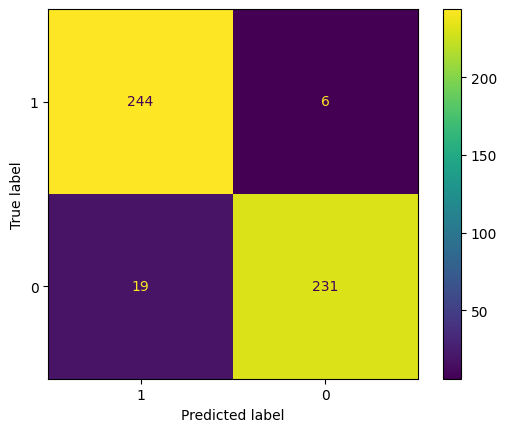

[inf  1.  0.]


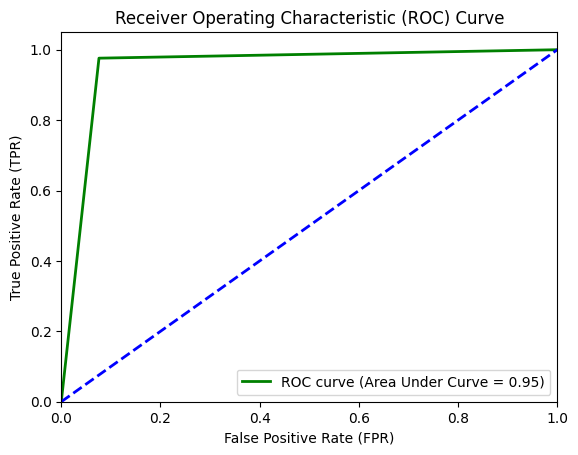

In [25]:
#Ada performance report
performance(test_data_cleaned['label_binary'],predictions_ada)

In [26]:
%%time
#Curie predictions
predictions_curie = predict(test_data_cleaned,"curie:ft-heriot-watt-university:cleaned-01-aug-curie-2023-08-14-12-31-57")

CPU times: user 1.18 s, sys: 204 ms, total: 1.39 s
Wall time: 2min 23s


Accuracy: 94.8%
[244   6  20 230]
TP: 244
FP: 20
TN: 230
FN: 6
Sensitivity: 97.6%
Specificity: 92.0%
Precision: 92.424%
Recall: 97.6%
f1: 94.942%


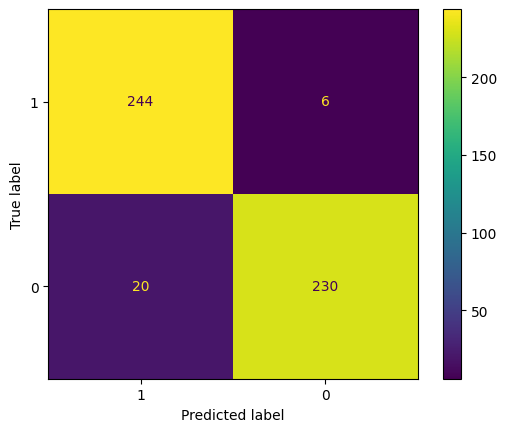

[inf  1.  0.]


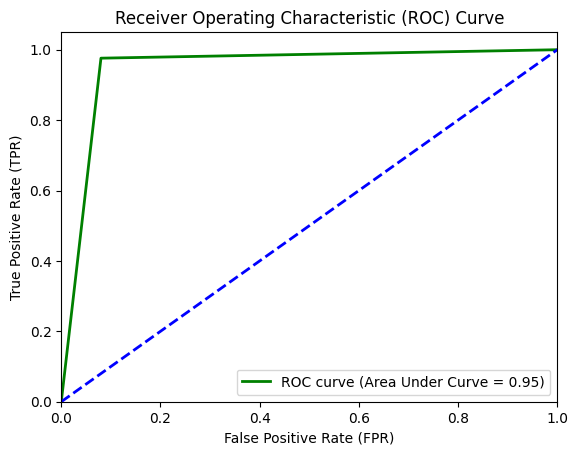

In [27]:
#Curie performance report
performance(test_data_cleaned['label_binary'],predictions_curie)

<h2>Results<h2>
    <h5>For clean tweets, both Ada and Curie performed almost identically only 1 extra tweet was misclassified by Curie.<h5>
    

| Model       | Accuracy | TP  | FP | TN  | FN | Sensitivity | Specificity | Precision | Recall | f1-score |
|-------------|----------|-----|----|-----|----|-------------|-------------|-----------|--------|----------|
| GPT - Ada   | 95.0%    | 244 | 19 | 231 | 6  | 97.6%       | 92.4%       | 92.776%   | 97.6%  | 95.127%  |
| GPT - Curie | 94.8%    | 244 | 20 | 230 | 6  | 97.6%       | 92.0%       | 92.424%   | 97.6%  | 94.942%  |